In [1]:
# connect google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

def getOpticalFlow(video):
    """Calculate dense optical flow of input video
    Args:
        video: the input video with shape of [frames,height,width,channel]. dtype=np.array
    Returns:
        flows_x: the optical flow at x-axis, with the shape of [frames,height,width,channel]
        flows_y: the optical flow at y-axis, with the shape of [frames,height,width,channel]
    """
    # initialize the list of optical flows
    gray_video = []
    for i in range(len(video)):
        img = cv2.cvtColor(video[i], cv2.COLOR_RGB2GRAY)
        gray_video.append(np.reshape(img, (224, 224, 1)))

    flows = []
    for i in range(0, len(video) - 1):
        # calculate optical flow between each pair of frames
        flow = cv2.calcOpticalFlowFarneback(gray_video[i], gray_video[i + 1], None, 0.5, 3, 15, 3, 5, 1.2,
                                            cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
        # subtract the mean in order to eliminate the movement of camera
        flow[..., 0] -= np.mean(flow[..., 0])
        flow[..., 1] -= np.mean(flow[..., 1])
        # normalize each component in optical flow
        flow[..., 0] = cv2.normalize(flow[..., 0], None, 0, 255, cv2.NORM_MINMAX)
        flow[..., 1] = cv2.normalize(flow[..., 1], None, 0, 255, cv2.NORM_MINMAX)
        # Add into list
        flows.append(flow)

    # Padding the last frame as empty array
    flows.append(np.zeros((224, 224, 2)))

    return np.array(flows, dtype=np.float32)


def Video2Npy(file_path, resize=(224,224)):
    """Load video and tansfer it into .npy format
    Args:
        file_path: the path of video file
        resize: the target resolution of output video
    Returns:
        frames: gray-scale video
        flows: magnitude video of optical flows
    """
    # Load video
    cap = cv2.VideoCapture(file_path)
    # Get number of frames
    len_frames = int(cap.get(7))
    # Extract frames from video
    try:
        frames = []
        for i in range(len_frames-1):
            _, frame = cap.read()
            frame = cv2.resize(frame,resize, interpolation=cv2.INTER_AREA)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = np.reshape(frame, (224,224,3))
            frames.append(frame)
    except:
        print("Error: ", file_path, len_frames,i)
    finally:
        frames = np.array(frames)
        cap.release()

    # Get the optical flow of video
    flows = getOpticalFlow(frames)

    # Visualize optical flow map
    optical_flow_map = farneback_visual(flows)

    result = np.zeros((len(flows),224,224,5))
    result[...,:3] = frames
    result[...,3:] = flows

    return result

def farneback_visual(flows):
    # visualization farneback optical flow map
    # save the map as 'farneback_optical_flow.mp4'
    #인지
    pass


def Save2Npy(file_dir, save_dir):   # modify this code to save the npy files for your directory or path
    """Transfer all the videos and save them into specified directory
    Args:
        file_dir: source folder of target videos
        save_dir: destination folder of output .npy files
    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    # List the files
    videos = os.listdir(file_dir)
    for v in tqdm(videos):
        # Split video name
        video_name = v.split('.')[0]
        # Get src
        video_path = os.path.join(file_dir, v)
        # Get dest
        save_path = os.path.join(save_dir, video_name+'.npy')
        # Load and preprocess video
        data = Video2Npy(file_path=video_path, resize=(224,224))
        data = np.uint8(data)
        # Save as .npy file
        np.save(save_path, data)

    return None

In [5]:
source_path = '/content/drive/MyDrive/Colab Notebooks/IC_PBL/dataset/raw_video.zip (Unzipped Files)'
target_path = '/content/drive/MyDrive/Colab Notebooks/IC_PBL/dataset/npy_dataset'

for f1 in ['train', 'val', 'test']:
    for f2 in ['Fight', 'NonFight']:
        path1 = os.path.join(source_path, f1, f2)
        path2 = os.path.join(target_path, f1, f2)
        Save2Npy(file_dir=path1, save_dir=path2)

100%|██████████| 10/10 [00:50<00:00,  5.07s/it]


In [6]:
from multiprocessing import allow_connection_pickling
import torch
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
import cv2

class DataGenerator(Dataset):

    ### basic function templates for Dataset class in Pytorch : __init__, __len__, __getitem__###
    def __init__(self, directory, data_augmentation=True, phase='train'):
        self.phase=phase
        self.directory = directory
        self.data_aug = data_augmentation
        self.X_path, self.Y_dict = self.search_data()
        self.print_stats()

    def __len__(self):
        steps_per_epoch = int(len(self.X_path))
        return steps_per_epoch

    # get data and label corresponding to index using 'data_generation function'
    def __getitem__(self, index):
        data, label = self.data_generation(self.X_path[index])
        return data.float(), label

    #############################################################
    # -----------------codes down from this line are provided.------------------- #
    # call raw data using data path, and data processing including 'uniform sampling', 'color jittering', 'random flip', and 'normalize'
    #############################################################

    def load_data(self, path):
        data = np.load(path, mmap_mode='r') # Read the raw data from path
        data = self.uniform_sampling(data, target_frames=64) # Randomly sample number of target frames
        if self.data_aug: # If data is augmented...
            data[..., :3] = self.color_jitter(data[..., :3])
            data = self.random_flip(data, prob=0.5) # Random flip image into random direction
        data[..., :3] = self.normalize(data[..., :3]) # Normalize RGB
        data[..., 3:] = self.normalize(data[..., 3:]) # Normalize optical flows
        return data

    # shuffle data
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    # Normalize data
    def normalize(self, data):
        mean = data.mean()
        std = data.std()
        return (data - mean) / std

    def random_flip(self, video, prob):
        s = np.random.rand()
        if s < prob:
            video = np.flip(video, (2,)) # Flip in width direction
        return video

    def uniform_sampling(self, video, target_frames=64):
        # get total frames of input video and calculate sampling interval
        len_frames = int(len(video))
        interval = int(np.ceil(len_frames/target_frames))
        # init empty list for sampled video and
        sampled_video = []
        for i in range(0,len_frames,interval):
            sampled_video.append(video[i])
        # calculate numer of padded frames and fix it
        num_pad = target_frames - len(sampled_video) # num pad = # target frame - # current frame
        padding = []
        if num_pad>0:
            for i in range(-num_pad,0):
                try:
                    padding.append(video[i]) # Fill with the last video frame
                except:
                    padding.append(video[0])
            sampled_video += padding # Add padding results
        # get sampled video
        return np.array(sampled_video, dtype=np.float32)

    # Jitter = spread values
    def color_jitter(self, video):
        s_jitter = np.random.uniform(-0.2, 0.2)
        v_jitter = np.random.uniform(-30, 30)
        for i in range(len(video)):
            hsv = cv2.cvtColor(np.array(video[i]), cv2.COLOR_RGB2HSV) # Convert RGB -> HSV
            s = hsv[..., 1] + s_jitter # saturation jitter
            v = hsv[..., 2] + v_jitter # Value jitter
            # Flip
            s[s < 0] = 0
            s[s > 1] = 1
            v[v < 0] = 0
            v[v > 255] = 255
            hsv[..., 1] = s # set jittered saturation
            hsv[..., 2] = v # Set jittered value
            video[i] = torch.Tensor(cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)) # Convert HSV -> RGB again
        return video

    # print current state sof the Dataset class
    def print_stats(self):
            self.n_files = len(self.X_path)
            self.n_classes = len(self.dirs)
            self.indexes = np.arange(len(self.X_path))
            np.random.shuffle(self.indexes)
            print("Found {} files belonging to {} classes.".format(self.n_files, self.n_classes))
            for i, label in enumerate(self.dirs):
                print('{:10s} : {}'.format(label, i))

    #############################################################
    # Fill the missing part of the code with functions given above
    #############################################################

    # get data and label(one-hot encoded) from path list/dictionary
    def search_data(self):
        X_path = []
        Y_dict = {}
        self.dirs = sorted(os.listdir(self.directory)) # Get sorted file directories
        one_hots = np.eye(len(self.dirs))  # One-hot encoded vector
        for i, folder in enumerate(self.dirs):
            folder_path = os.path.join(self.directory, folder)  # folder_path = ...train/Fight or ...train/NonFight
            for file in os.listdir(folder_path):
                # Add file path into X_path
                # Assign one hot encoded vector into Y_dict
                file_path = os.path.join(folder_path, file)
                X_path.append(file_path)
                #레이블 할당
                Y_dict[file_path] = one_hots[i]

        return X_path, Y_dict

    # define batch x using 'load_data' function and batch_y from self.Y_dict.
    def data_generation(self, batch_path):
        batch_x = np.array(self.load_data(batch_path))
        batch_y = np.array(self.Y_dict[batch_path])

        # Transfer numpy array to tensor
        batch_x = torch.from_numpy(batch_x)
        batch_y = torch.from_numpy(batch_y).float()

        return batch_x, batch_y

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FusionModel(nn.Module):
    def __init__(self):
        super(FusionModel, self).__init__()
        self.relu=nn.ReLU(inplace=True)

        # RGB layers
        self.rgb_conv1a = nn.Conv3d(3, 16, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1))
        self.rgb_conv1b = nn.Conv3d(16, 16, kernel_size=(3, 1, 1), stride=1, padding=(1, 0, 0))
        self.rgb_pool1a = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        self.rgb_conv1c = nn.Conv3d(16, 16, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1))
        self.rgb_conv1d = nn.Conv3d(16, 16, kernel_size=(3, 1, 1), stride=1, padding=(1, 0, 0))
        self.rgb_pool1b = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        self.rgb_conv2a = nn.Conv3d(16, 32, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1))
        self.rgb_conv2b = nn.Conv3d(32, 32, kernel_size=(3, 1, 1), stride=1, padding=(1, 0, 0))
        self.rgb_pool2a = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        self.rgb_conv2c = nn.Conv3d(32, 32, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1))
        self.rgb_conv2d = nn.Conv3d(32, 32, kernel_size=(3, 1, 1), stride=1, padding=(1, 0, 0))
        self.rgb_pool2b = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        # Optical flow layers
        self.opt_conv1a = nn.Conv3d(2, 16, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1))
        self.opt_conv1b = nn.Conv3d(16, 16, kernel_size=(3, 1, 1), stride=1, padding=(1, 0, 0))
        self.opt_pool1a = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        self.opt_conv1c = nn.Conv3d(16, 16, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1))
        self.opt_conv1d = nn.Conv3d(16, 16, kernel_size=(3, 1, 1), stride=1, padding=(1, 0, 0))
        self.opt_pool1b = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        self.opt_conv2a = nn.Conv3d(16, 32, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1))
        self.opt_conv2b = nn.Conv3d(32, 32, kernel_size=(3, 1, 1), stride=1, padding=(1, 0, 0))
        self.opt_pool2a = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        self.opt_conv2c = nn.Conv3d(32, 32, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1))
        self.opt_conv2d = nn.Conv3d(32, 32, kernel_size=(3, 1, 1), stride=1, padding=(1, 0, 0))
        self.opt_pool2b = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        # Fusion and Pooling
        self.fusion_pool = nn.MaxPool3d(kernel_size=(8, 1, 1), stride=(8, 1, 1))

        # Merge Block
        self.merge_conv1a = nn.Conv3d(32, 64, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1))
        self.merge_conv1b = nn.Conv3d(64, 64, kernel_size=(3, 1, 1), stride=1, padding=(1, 0, 0))
        self.merge_pool1a = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.merge_conv1c = nn.Conv3d(64, 64, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1))
        self.merge_conv1d = nn.Conv3d(64, 64, kernel_size=(3, 1, 1), stride=1, padding=(1, 0, 0))
        self.merge_pool1b = nn.MaxPool3d(kernel_size=(2, 3, 3), stride=(2, 2, 2))

        self.merge_conv2a = nn.Conv3d(64, 128, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1))
        self.merge_conv2b = nn.Conv3d(128, 128, kernel_size=(3, 1, 1), stride=1, padding=(1, 0, 0))
        self.merge_pool2a = nn.MaxPool3d(kernel_size=(2, 3, 3), stride=(2, 2, 2))

        # Fully Connected Layers
        self.fc1 = nn.Linear(128, 128)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 2)

        # Initialize weights
        self.__init_weight()

    def forward(self, x):
        x = x.transpose(2,4).transpose(3,4).transpose(1,2)
        rgb = x[:,:3,:,:,:]  # RGB
        opt = x[:,3:5,:,:,:] # Optical Flow

        # RGB blocks
        rgb = self.relu(self.rgb_conv1a(rgb))
        rgb = self.relu(self.rgb_conv1b(rgb))
        rgb = self.rgb_pool1a(rgb)

        # Residual block: rgb_conv1c/d (16->16)
        rgb_input = rgb
        rgb = self.relu(self.rgb_conv1c(rgb))
        rgb = self.relu(self.rgb_conv1d(rgb))
        rgb = rgb + rgb_input
        rgb = self.rgb_pool1b(rgb)

        rgb = self.relu(self.rgb_conv2a(rgb))
        rgb = self.relu(self.rgb_conv2b(rgb))
        rgb = self.rgb_pool2a(rgb)

        # Residual block: rgb_conv2c/d (32->32)
        rgb_input = rgb
        rgb = self.relu(self.rgb_conv2c(rgb))
        rgb = self.relu(self.rgb_conv2d(rgb))
        rgb = rgb + rgb_input
        rgb = self.rgb_pool2b(rgb)

        # Optical Flow blocks
        opt = self.relu(self.opt_conv1a(opt))
        opt = self.relu(self.opt_conv1b(opt))
        opt = self.opt_pool1a(opt)

        # Residual block: opt_conv1c/d (16->16)
        opt_input = opt
        opt = self.relu(self.opt_conv1c(opt))
        opt = self.relu(self.opt_conv1d(opt))
        opt = opt + opt_input
        opt = self.opt_pool1b(opt)

        opt = self.relu(self.opt_conv2a(opt))
        opt = self.relu(self.opt_conv2b(opt))
        opt = self.opt_pool2a(opt)

        # Residual block: opt_conv2c/d (32->32)
        opt_input = opt
        opt = self.relu(self.opt_conv2c(opt))
        opt = self.relu(self.opt_conv2d(opt))
        opt = opt + opt_input
        opt = self.opt_pool2b(opt)

        # Fusion
        fused = rgb * opt
        fused = self.fusion_pool(fused)

        # Merging blocks
        fused = self.relu(self.merge_conv1a(fused))
        fused = self.relu(self.merge_conv1b(fused))
        fused = self.merge_pool1a(fused)

        # Residual block: merge_conv1c/d (64->64)
        merged_input = fused
        fused = self.relu(self.merge_conv1c(fused))
        fused = self.relu(self.merge_conv1d(fused))
        fused = fused + merged_input
        fused = self.merge_pool1b(fused)

        fused = self.relu(self.merge_conv2a(fused))
        fused = self.relu(self.merge_conv2b(fused))
        fused = self.merge_pool2a(fused)

        # Fully Connected Layers
        x = fused.view(fused.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x

    def __init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

In [8]:
!pip install wandb

In [9]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from tqdm import tqdm
import wandb


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# define model, optimizer and criterion
model = FusionModel().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=1e-6, nesterov=True)
#optimizer = optim.Adam(model.parameters(), lr=0.003, betas=(0.9, 0.999), weight_decay=1e-6)
loss_fn = nn.CrossEntropyLoss().to(device)

trainset_path = '/content/drive/MyDrive/Colab Notebooks/IC_PBL/dataset/npy_dataset/train'
validation_path = '/content/drive/MyDrive/Colab Notebooks/IC_PBL/dataset/npy_dataset/val'

# define dataset and dataloader
train_dataset = DataGenerator(directory=trainset_path, data_augmentation=True)
val_dataset = DataGenerator(directory=validation_path, data_augmentation=True)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=0)

# epoch = 30
# learning rate = 0.003

# optimizer = SGD
# weight decay = 1e-6
# momentum = 0.9
# nesterov = True
# gamma = 0.7

# loss = CrossEntropy

# assign device cpu or gpu
min_loss = np.inf


Found 160 files belonging to 2 classes.
Fight      : 0
NonFight   : 1
Found 40 files belonging to 2 classes.
Fight      : 0
NonFight   : 1


In [10]:
def _train():

    model.train()
    acc_temp = 0
    running_loss = 0

    # forward propagation and backpropagation
    # calculate accuracy and loss on training set
    for data, label in tqdm(train_loader):

        data = data.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        outputs = model(data)

        #print("outputs", outputs)
        #print("label", label)
        #print("max(label, 1)", torch.max(label, 1))
        #print("max(label, 1)[1]", torch.max(label, 1)[1])


        loss = loss_fn(outputs, torch.max(label, 1)[1])  # 원-핫 레이블을 클래스 인덱스로 변환

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)
        preds = torch.argmax(outputs, dim=1)
        #print("preds", preds)
        acc_temp += torch.sum(preds == torch.max(label, 1)[1])
        #print("acc_temp", acc_temp)
        #print('_______________________________________')

    train_acc = acc_temp / len(train_loader.dataset)
    train_loss = running_loss / len(train_loader.dataset)

    return train_acc, train_loss

In [11]:
def _val():
    model.eval()
    with torch.no_grad():
        running_loss_val = 0
        acc_temp_val =0

        # calculate accuracy and loss on validation set
        for data, label in tqdm(val_loader):
            data = data.to(device)
            label = label.to(device)

            outputs = model(data)

            # Debugging Outputs
            #print("Output Shape: ", outputs.shape)
            #print("Label Shape: ", label.shape)
            #print("Output: ", outputs)


            loss = loss_fn(outputs, torch.max(label, 1)[1])

            running_loss_val += loss.item() * data.size(0)
            preds = torch.argmax(outputs, dim=1)
            acc_temp_val += torch.sum(preds == torch.max(label, 1)[1])

    val_acc = acc_temp_val / len(val_loader.dataset)
    val_loss = running_loss_val / len(val_loader.dataset)

    return val_acc.item(), val_loss

In [12]:
import random
import numpy as np

scheduler = StepLR(optimizer, step_size=10, gamma=0.7)
seed=1
random.seed(seed)
np.random.seed(seed)
device='cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(seed)
if device =='cuda':
    print('gpu device is using')
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False

#wandb.login()
wandb.init()

num_epochs = 30  # 에포크 수를 정의합니다
for epoch in range(1, num_epochs + 1):
    # Perform training and validation
    # Save the weights
    # Log the training and validation results

    print(f'Epoch {epoch}/{num_epochs}')

    # 훈련 함수 호출
    train_acc, train_loss = _train()

    # 검증 함수 호출
    val_acc, val_loss = _val()

    #헉습률 추출
    current_lr = optimizer.param_groups[0]['lr']

    # 학습률 스케줄러 업데이트
    scheduler.step()

    # 검증 손실이 감소하면 모델 가중치 저장
    if val_loss < min_loss:
        min_loss = val_loss
        torch.save(model.state_dict(), f'best_model_epoch_ver3_{epoch}.pth')
        print(f'Validation loss decreased, model saved as best_model_epoch_{epoch}.pth')

    # 훈련 및 검증 결과를 로깅
    wandb.log({
        'epoch': epoch,
        'train_loss': train_loss,
        'train_accuracy': train_acc,
        'val_loss': val_loss,
        'val_accuracy': val_acc,
        'learning_rate': current_lr
    })

    # 결과 출력
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

gpu device is using


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch 1/30


100%|██████████| 10/10 [00:36<00:00,  3.65s/it]


Validation loss decreased, model saved as best_model_epoch_1.pth
Train Loss: 0.7060, Train Acc: 0.4750
Val Loss: 0.6887, Val Acc: 0.5000
Epoch 2/30


100%|██████████| 10/10 [00:37<00:00,  3.70s/it]


Validation loss decreased, model saved as best_model_epoch_2.pth
Train Loss: 0.6891, Train Acc: 0.5188
Val Loss: 0.6844, Val Acc: 0.5750
Epoch 3/30


100%|██████████| 10/10 [00:36<00:00,  3.65s/it]


Validation loss decreased, model saved as best_model_epoch_3.pth
Train Loss: 0.6856, Train Acc: 0.5813
Val Loss: 0.6777, Val Acc: 0.5250
Epoch 4/30


100%|██████████| 10/10 [00:36<00:00,  3.62s/it]


Validation loss decreased, model saved as best_model_epoch_4.pth
Train Loss: 0.6750, Train Acc: 0.5625
Val Loss: 0.6710, Val Acc: 0.5000
Epoch 5/30


100%|██████████| 10/10 [00:36<00:00,  3.63s/it]


Train Loss: 0.6616, Train Acc: 0.6125
Val Loss: 0.6891, Val Acc: 0.5000
Epoch 6/30


100%|██████████| 10/10 [00:37<00:00,  3.72s/it]


Validation loss decreased, model saved as best_model_epoch_6.pth
Train Loss: 0.6790, Train Acc: 0.6062
Val Loss: 0.6544, Val Acc: 0.7250
Epoch 7/30


100%|██████████| 10/10 [00:36<00:00,  3.64s/it]


Validation loss decreased, model saved as best_model_epoch_7.pth
Train Loss: 0.6539, Train Acc: 0.6375
Val Loss: 0.6506, Val Acc: 0.6750
Epoch 8/30


100%|██████████| 10/10 [00:36<00:00,  3.61s/it]


Validation loss decreased, model saved as best_model_epoch_8.pth
Train Loss: 0.6308, Train Acc: 0.6813
Val Loss: 0.6314, Val Acc: 0.6500
Epoch 9/30


100%|██████████| 10/10 [00:34<00:00,  3.46s/it]


Validation loss decreased, model saved as best_model_epoch_9.pth
Train Loss: 0.6138, Train Acc: 0.6500
Val Loss: 0.5845, Val Acc: 0.8250
Epoch 10/30


100%|██████████| 10/10 [00:36<00:00,  3.63s/it]


Validation loss decreased, model saved as best_model_epoch_10.pth
Train Loss: 0.5761, Train Acc: 0.7125
Val Loss: 0.4784, Val Acc: 0.9000
Epoch 11/30


100%|██████████| 10/10 [00:36<00:00,  3.68s/it]


Validation loss decreased, model saved as best_model_epoch_11.pth
Train Loss: 0.5659, Train Acc: 0.7375
Val Loss: 0.4562, Val Acc: 0.9000
Epoch 12/30


100%|██████████| 10/10 [00:34<00:00,  3.41s/it]


Validation loss decreased, model saved as best_model_epoch_12.pth
Train Loss: 0.5436, Train Acc: 0.7438
Val Loss: 0.4359, Val Acc: 0.8000
Epoch 13/30


100%|██████████| 10/10 [00:33<00:00,  3.33s/it]


Validation loss decreased, model saved as best_model_epoch_13.pth
Train Loss: 0.5405, Train Acc: 0.7375
Val Loss: 0.4135, Val Acc: 0.8750
Epoch 14/30


100%|██████████| 10/10 [00:33<00:00,  3.35s/it]


Validation loss decreased, model saved as best_model_epoch_14.pth
Train Loss: 0.5083, Train Acc: 0.7875
Val Loss: 0.3827, Val Acc: 0.9000
Epoch 15/30


100%|██████████| 10/10 [00:33<00:00,  3.34s/it]


Validation loss decreased, model saved as best_model_epoch_15.pth
Train Loss: 0.4571, Train Acc: 0.7812
Val Loss: 0.3812, Val Acc: 0.9000
Epoch 16/30


100%|██████████| 10/10 [00:34<00:00,  3.43s/it]


Validation loss decreased, model saved as best_model_epoch_16.pth
Train Loss: 0.4733, Train Acc: 0.7500
Val Loss: 0.3562, Val Acc: 0.9000
Epoch 17/30


100%|██████████| 10/10 [00:32<00:00,  3.28s/it]


Validation loss decreased, model saved as best_model_epoch_17.pth
Train Loss: 0.4481, Train Acc: 0.8188
Val Loss: 0.3506, Val Acc: 0.9000
Epoch 18/30


100%|██████████| 10/10 [00:32<00:00,  3.28s/it]


Train Loss: 0.5130, Train Acc: 0.7812
Val Loss: 0.4883, Val Acc: 0.8000
Epoch 19/30


100%|██████████| 10/10 [00:32<00:00,  3.27s/it]


Train Loss: 0.4971, Train Acc: 0.7750
Val Loss: 0.3724, Val Acc: 0.8500
Epoch 20/30


100%|██████████| 10/10 [00:34<00:00,  3.44s/it]


Train Loss: 0.3666, Train Acc: 0.8500
Val Loss: 0.4543, Val Acc: 0.7750
Epoch 21/30


100%|██████████| 10/10 [00:30<00:00,  3.10s/it]


Train Loss: 0.3764, Train Acc: 0.8625
Val Loss: 0.4598, Val Acc: 0.7750
Epoch 22/30


100%|██████████| 10/10 [00:29<00:00,  2.90s/it]


Train Loss: 0.3447, Train Acc: 0.8500
Val Loss: 0.4326, Val Acc: 0.8250
Epoch 23/30


100%|██████████| 10/10 [00:31<00:00,  3.19s/it]


Train Loss: 0.3585, Train Acc: 0.8313
Val Loss: 0.5028, Val Acc: 0.8250
Epoch 24/30


100%|██████████| 10/10 [00:33<00:00,  3.32s/it]


Validation loss decreased, model saved as best_model_epoch_24.pth
Train Loss: 0.4816, Train Acc: 0.7750
Val Loss: 0.3297, Val Acc: 0.8750
Epoch 25/30


100%|██████████| 10/10 [00:32<00:00,  3.28s/it]


Train Loss: 0.3591, Train Acc: 0.8375
Val Loss: 0.9664, Val Acc: 0.5250
Epoch 26/30


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


Train Loss: 0.3778, Train Acc: 0.8438
Val Loss: 0.4356, Val Acc: 0.7750
Epoch 27/30


100%|██████████| 10/10 [00:31<00:00,  3.17s/it]


Train Loss: 0.2622, Train Acc: 0.9187
Val Loss: 0.4410, Val Acc: 0.8000
Epoch 28/30


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


Train Loss: 0.4390, Train Acc: 0.8250
Val Loss: 0.3676, Val Acc: 0.8500
Epoch 29/30


100%|██████████| 10/10 [00:29<00:00,  2.92s/it]


Train Loss: 0.3153, Train Acc: 0.8625
Val Loss: 0.3436, Val Acc: 0.8500
Epoch 30/30


100%|██████████| 10/10 [00:31<00:00,  3.18s/it]

Validation loss decreased, model saved as best_model_epoch_30.pth
Train Loss: 0.1871, Train Acc: 0.9500
Val Loss: 0.3182, Val Acc: 0.9000


In [13]:
best_model = '/content/best_model_epoch_ver3_30.pth'
test_path = '/content/drive/MyDrive/Colab Notebooks/IC_PBL/dataset/npy_dataset/test'

test_dataset = DataGenerator(directory=test_path, data_augmentation=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=0)

Found 20 files belonging to 2 classes.
Fight      : 0
NonFight   : 1


<ipython-input-15-6362dbd0e123>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model))


test accuracy : 0.80
AUROC: 0.88


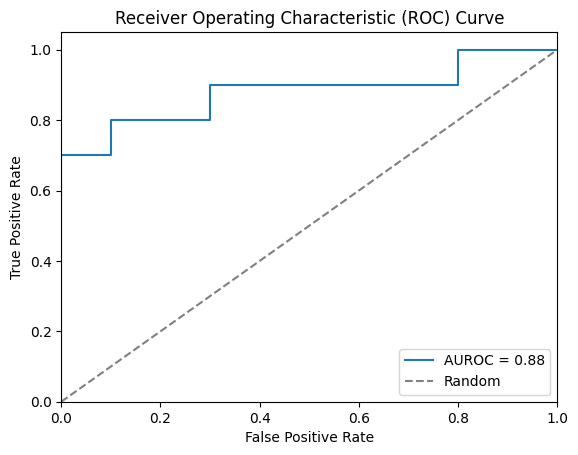

In [15]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

model.load_state_dict(torch.load(best_model))
model.eval()

all_labels = []
all_probs = []


with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        inputs = inputs.cuda() if torch.cuda.is_available() else inputs
        labels = labels.cuda() if torch.cuda.is_available() else labels

        # labels가 one-hot이므로 argmax를 이용해 정수 라벨로 변환
        labels = torch.argmax(labels, dim=1)

        outputs = model(inputs)

        # softmax로 확률 변환 (이진 분류 가정: positive 클래스 확률)
        probs = F.softmax(outputs, dim=1)[:, 1]

        # 예측 라벨
        preds = torch.argmax(outputs, dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # CPU로 이동 후 numpy 변환
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

    accuracy = correct / total
    print("test accuracy : {:.2f}".format(accuracy))

    # AUROC 계산
    auroc = roc_auc_score(all_labels, all_probs)
    print("AUROC: {:.2f}".format(auroc))

    # ROC 커브 계산
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

    # ROC 커브 플롯
    plt.figure()
    plt.plot(fpr, tpr, label='AUROC = {:.2f}'.format(auroc))
    plt.plot([0,1],[0,1],'--', color='gray', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()